# Apply Naive Bayes on Donors Choose dataset

### Dataset 

###### DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
How to focus volunteer time on the applications that need the most assistance###### About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.###### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


### Objective 

###### The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

Apply Multinomial NB on these feature sets
* Set 1: categorical, numerical features + preprocessed_eassay (BOW)
* Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)
    

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from scipy.stats import randint as sp_randint
from tqdm import tqdm
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import math


In [2]:
#Loading data -- nrows=50,000

data = pd.read_csv('preprocessed_data.csv', nrows=50000)
print("Number of data points in train data", data.shape)


Number of data points in train data (50000, 9)


In [3]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
print(X.shape)

(50000, 8)


In [4]:
#---1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)


In [5]:
#----1.3 Make Data Model Ready: 

#--- Set 1: categorical, numerical features + preprocessed_eassay (BOW)

# encoding text features: preprocessed_eassay (BOW)

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)


After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [27]:
# Make Data Model Ready: encoding numerical, categorical features

# encoding categorical features: School State

vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

#Creating a list to store the index detail for feature importance
feature_list = []

name1 = vectorizer.get_feature_names()

for ele in name1:
    feature_list.append(ele)


After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [28]:
# encoding categorical features: teacher_prefix

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

name2 = vectorizer.get_feature_names()

for ele in name2:
    feature_list.append(ele)
    

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [29]:
# encoding categorical features: project_grade_category

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

name3 = vectorizer.get_feature_names()

for ele in name3:
    feature_list.append(ele)
    

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [30]:
# encoding categorical features: clean_categories

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clcat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clcat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clcat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clcat_ohe.shape, y_train.shape)
print(X_cv_clcat_ohe.shape, y_cv.shape)
print(X_test_clcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

name4 = vectorizer.get_feature_names()

for ele in name4:
    feature_list.append(ele)
    

After vectorizations
(22445, 7) (22445,)
(11055, 7) (11055,)
(16500, 7) (16500,)
['appliedlearning', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds']


In [31]:
# encoding categorical features: clean_subcategories

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clsubcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clsubcat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clsubcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clsubcat_ohe.shape, y_train.shape)
print(X_cv_clsubcat_ohe.shape, y_cv.shape)
print(X_test_clsubcat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

name5 = vectorizer.get_feature_names()

for ele in name5:
    feature_list.append(ele)
    

After vectorizations
(22445, 28) (22445,)
(11055, 28) (11055,)
(16500, 28) (16500,)
['appliedsciences', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts']


In [32]:
# encoding numerical features: Price

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

feature_list.append("price")


After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [33]:

# encoding numerical features: teacher_number_of_previously_posted_projects

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prepro_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prepro_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prepro_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_prepro_norm.shape, y_train.shape)
print(X_cv_prepro_norm.shape, y_cv.shape)
print(X_test_prepro_norm.shape, y_test.shape)

feature_list.append("previously_posted_projects")


After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [34]:

#--- Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)

# encoding text features: preprocessed_eassay (TFIDF)

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

name8 = vectorizer.get_feature_names()

for ele in name8:
    feature_list.append(ele)
    

After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [35]:
# --- Concatinating all the features

###### SET 1 ########

X_tr1 = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_clcat_ohe,X_train_clsubcat_ohe,X_train_price_norm,X_train_prepro_norm,X_train_essay_bow)).tocsr()
X_cr1 = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_clcat_ohe,X_cv_clsubcat_ohe,X_cv_price_norm,X_cv_prepro_norm,X_cv_essay_bow)).tocsr()
X_te1 = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_clcat_ohe,X_test_clsubcat_ohe,X_test_price_norm,X_test_prepro_norm,X_test_essay_bow)).tocsr()

print("Final Data matrix 1")
print(X_tr1.shape, y_train.shape)
print(X_cr1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)

Final Data matrix 1
(22445, 5097) (22445,)
(11055, 5097) (11055,)
(16500, 5097) (16500,)


In [36]:
# --- Concatinating all the features

###### SET 2 ########

X_tr2 = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_clcat_ohe,X_train_clsubcat_ohe,X_train_price_norm,X_train_prepro_norm,X_train_essay_tfidf)).tocsr()
X_cr2 = hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_clcat_ohe,X_cv_clsubcat_ohe,X_cv_price_norm,X_cv_prepro_norm,X_cv_essay_tfidf)).tocsr()
X_te2 = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_clcat_ohe,X_test_clsubcat_ohe,X_test_price_norm,X_test_prepro_norm,X_test_essay_tfidf)).tocsr()

print("Final Data matrix 2")
print(X_tr2.shape, y_train.shape)
print(X_cr2.shape, y_cv.shape)
print(X_te2.shape, y_test.shape) 


Final Data matrix 2
(22445, 5097) (22445,)
(11055, 5097) (11055,)
(16500, 5097) (16500,)


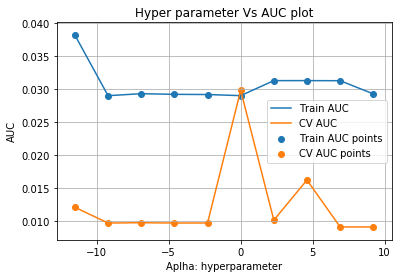

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038156,0.011771,0.012058,0.003156,1e-05,{'alpha': 1e-05},0.677585,0.687480,0.697484,0.687516,0.008124,4
1,0.028983,0.000179,0.009678,0.000065,0.0001,{'alpha': 0.0001},0.677619,0.687470,0.697494,0.687528,0.008114,3
2,0.029283,0.000078,0.009724,0.000046,0.001,{'alpha': 0.001},0.677675,0.687453,0.697506,0.687545,0.008096,2
3,0.029186,0.000117,0.009678,0.000022,0.01,{'alpha': 0.01},0.677736,0.687430,0.697520,0.687562,0.008078,1
4,0.029154,0.000116,0.009681,0.000038,0.1,{'alpha': 0.1},0.677709,0.687302,0.697489,0.687500,0.008077,5


In [37]:
#### Appling Multinomial NB: BOW featurization

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import math

mnb = MultinomialNB(class_prior = [0.5, 0.5] )
parameters = {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
clf = RandomizedSearchCV(mnb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr1, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_fit_time']
train_auc_std= results['std_fit_time']
cv_auc = results['mean_score_time'] 
cv_auc_std= results['std_score_time']
alpha =  results['param_alpha']

log_a = alpha.apply(math.log)

plt.plot(log_a, train_auc, label='Train AUC')
plt.plot(log_a, cv_auc, label='CV AUC')

plt.scatter(log_a, train_auc, label='Train AUC points')
plt.scatter(log_a, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Aplha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()


In [38]:
best_alpha = 0.01

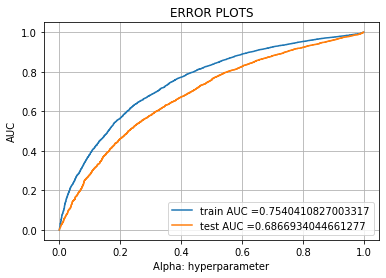

In [39]:
###### SET 1 ########
#### Run Set 1 test data on trained model ######

mnb = MultinomialNB(alpha = best_alpha)
mnb.fit(X_tr1, y_train)

# make class predictions for test
y_pred_class = mnb.predict(X_tr1)
y_train_pred = mnb.predict_proba(X_tr1)[:, 1]
y_pred_class = mnb.predict(X_te1)
y_test_pred = mnb.predict_proba(X_te1)[:, 1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [40]:

# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [41]:
# Confusion matrix for set 1

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


the maximum value of tpr*(1-fpr) 0.4795900583997078 for threshold 0.915
Train confusion matrix
[[ 2595  1000]
 [ 6326 12524]]
Test confusion matrix
[[1692  950]
 [5039 8819]]


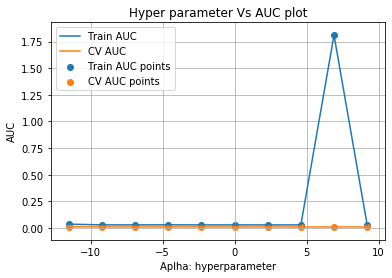

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035524,0.003947,0.012164,0.001932,1e-05,{'alpha': 1e-05},0.649957,0.670493,0.672416,0.664288,0.010164,1
1,0.028956,0.000469,0.009620,0.000035,0.0001,{'alpha': 0.0001},0.649954,0.670467,0.672414,0.664278,0.010160,2
2,0.028685,0.000127,0.009603,0.000075,0.001,{'alpha': 0.001},0.649936,0.670422,0.672396,0.664251,0.010155,3
3,0.029513,0.000716,0.010084,0.000776,0.01,{'alpha': 0.01},0.649733,0.670223,0.672244,0.664067,0.010169,4
4,0.028730,0.000104,0.009717,0.000147,0.1,{'alpha': 0.1},0.647743,0.668640,0.670878,0.662420,0.010419,5


In [42]:
###### SET 2 ########
#### Run Set 2 to train model ######
#### Appling Multinomial NB: TFIDF featurization #######


mnb = MultinomialNB(class_prior = [0.5, 0.5] )
parameters = {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
clf = RandomizedSearchCV(mnb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr2, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_fit_time']
train_auc_std= results['std_fit_time']
cv_auc = results['mean_score_time'] 
cv_auc_std= results['std_score_time']
alpha =  results['param_alpha']

log_a = alpha.apply(math.log)

plt.plot(log_a, train_auc, label='Train AUC')
plt.plot(log_a, cv_auc, label='CV AUC')

plt.scatter(log_a, train_auc, label='Train AUC points')
plt.scatter(log_a, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Aplha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()


In [43]:
best_alpha = 0.1

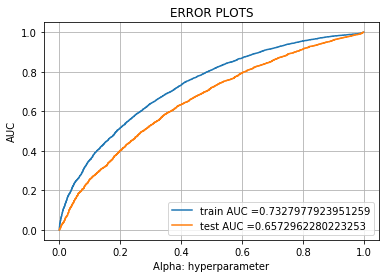

In [44]:

###### SET 2 ########
#### Run Set 2 test data on trained model ######

from sklearn.metrics import roc_curve, auc

mnb = MultinomialNB(alpha = best_alpha)
fit_set2 = mnb.fit(X_tr2, y_train)

# make class predictions for test
y_pred_class = mnb.predict(X_tr2)
y_train_pred = mnb.predict_proba(X_tr2)[:, 1]
y_pred_class = mnb.predict(X_te2)
y_test_pred = mnb.predict_proba(X_te2)[:, 1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [45]:
# Confusion matrix for set 2

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


the maximum value of tpr*(1-fpr) 0.44831496736920934 for threshold 0.844
Train confusion matrix
[[ 2425  1170]
 [ 6322 12528]]
Test confusion matrix
[[1554 1088]
 [4943 8915]]


In [46]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

# Top features for predicting the class labels 0 and 1 for set 2

neg_class_prob_sorted = fit_set2.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = fit_set2.feature_log_prob_[1, :].argsort()

lst1 = neg_class_prob_sorted[-20:]
lst2 = pos_class_prob_sorted[-20:]

pos_list = []
neg_list = []

for ele in reversed(lst1):
    word = feature_list[ele]
    pos_list.append(word)

print("Top features for positive class ")
print(pos_list)
print("*"*100)    

for ele in reversed(lst2):
    word = feature_list[ele]
    neg_list.append(word)

print("Top features for negative class ")
print(neg_list)


Top features for positive class 
['previously_posted_projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'ms', 'grades_3_5', 'literacy', 'mathematics', 'literature_writing', 'health_sports', 'grades_6_8', 'ca', 'specialneeds', 'specialneeds', 'students', 'appliedlearning', 'health_wellness', 'appliedsciences', 'grades_9_12']
****************************************************************************************************
Top features for negative class 
['previously_posted_projects', 'mrs', 'literacy_language', 'grades_prek_2', 'math_science', 'grades_3_5', 'ms', 'literacy', 'mathematics', 'literature_writing', 'health_sports', 'grades_6_8', 'ca', 'health_wellness', 'students', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'mr']


In [47]:
# http://zetcode.com/python/prettytable/

### Summary

from prettytable import PrettyTable

tab = PrettyTable()
tab.field_names = ["Vectorizer", "Model", "Hyper Parameter", "Train AUC Score", "Test AUC Score"]

tab.add_row(["BOW", "Multinomial NB", 0.01, 0.75, 0.68])
tab.add_row(["TFIDF", "Multinomial NB" , 0.1, 0.73, 0.65])

print(tab)


+------------+----------------+-----------------+-----------------+----------------+
| Vectorizer |     Model      | Hyper Parameter | Train AUC Score | Test AUC Score |
+------------+----------------+-----------------+-----------------+----------------+
|    BOW     | Multinomial NB |       0.01      |       0.75      |      0.68      |
|   TFIDF    | Multinomial NB |       0.1       |       0.73      |      0.65      |
+------------+----------------+-----------------+-----------------+----------------+
